### Research on Garch

In [6]:
import pandas as pd
import random
close = pd.read_parquet("../../db/tw/Adj_close.parquet")
close.index = pd.to_datetime(close.index)
stock_list_total = list(close.columns)
random_num = [random.randint(0, len(stock_list_total)) for _ in range(100)]
stock_list = [stock_list_total[i] for i in random_num]
stock_list = stock_list_total[-100:]

In [44]:
import yfinance as yf
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima_model import ARMA
# warnings.filterwarnings("ignore")
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2019-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

close = close.loc[train_start:pd.to_datetime("2024-01-01")][close.columns.intersection(stock_list)]
pct_change = close.pct_change().dropna(how='all', axis=0)
pct_change = pct_change.resample(resample_map['weekly']).sum()

/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_38621/483699672.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change = close.pct_change().dropna(how='all', axis=0)


In [24]:
x = np.array(pct)
mean_x = np.mean(x)
length_x = x.shape[0]

c_0 = ((x - mean_x) ** 2) # var
c_k = np.sum((x[:(length_x - 1)] - mean_x) * (x[1:] - mean_x))/length_x
np.mean(c_0), mean_x, c_k, len(x)

(0.00213564004468508, 0.0027636136382476325, 4.8645830888604365e-05, 313)

In [84]:
series = pct_change['8433.TWO'].iloc[-200:]
ma_value = pacf(series)
array_acf_best3 = np.argsort(abs(ma_value))[-4:-1][::-1] # is log
models = [sm.tsa.arima.ARIMA(series, order=(i, 0, 0)) for i in array_acf_best3]# order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fits = [model.fit() for model in models]
model_aics = [model_fit.aic for model_fit in model_fits]
prediction = model_fits[np.argmin(model_aics)].forecast().iloc[0]


(-291.6618277685014, -276.03080665257283)

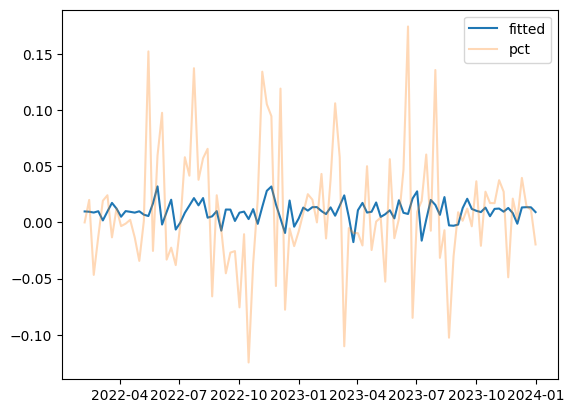

In [54]:
model = sm.tsa.arima.ARIMA(series, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit = model.fit()
model_fit.summary()
plt.plot(model_fit.fittedvalues, alpha=1, label='fitted')
plt.plot(series, alpha=0.3, label='pct')
plt.legend()
model_fit.aic, model_fit.bic

(-10.04200880496861,
 1.48774312645885e-17,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -250.7606120864166)

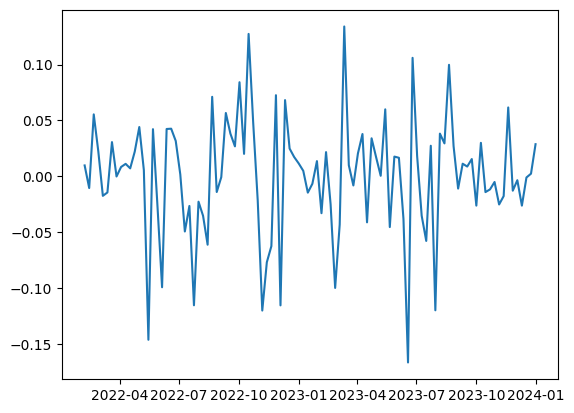

In [89]:
from statsmodels.tsa.stattools import adfuller

garch_data = model_fit.fittedvalues-series
plt.plot(garch_data)
adfuller(garch_data.dropna())

garch: predict next actual_value - prediction

and for ar model we get predicted value, 

+/- garch prediction of actual - prediction, we get actual prediction.

### Comparison: arima vs. arima garch